# INF8775 – Analyse et conception d’algorithmes
# TP3 – Automne 2025

LI, Bai Wu, 2179304

LIM, Guek Lang, 2119882

Note finale:

<u>**Date limite de remise :**</u>  6 décembre pour tous

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer des nouvelles cellules de code ou de texte.

- Vous pouvez utiliser des fichiers externes pour stocker des exemplaires et des résultats, mais nous devons être capable de comprendre facilement votre démarche et de la reproduire.

- <u>**IMPORTANT**</u> Remettez le fichier du notebook sur Moodle avec le nom `MATRICULE1_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et est une occasion de mettre en application les connaissances vues en cours. Vous devrez développer l'algorithme de votre choix pour essayer de résoudre le plus efficacement possible le problème donné. Une partie de la note sera accordée en fonction des résultats que vous obtiendrez par rapport aux autres équipes.

## Description du problème

Dans le cadre de ce TP, nous vous demandons de répondre à un problème combinatoire inspiré du puzzle [Selective Sponges](https://cacm.acm.org/opinion/upstart-puzzles-selective-sponges/) de Dennis E. Shasha (Communications of the ACM).
Le but est de construire un carré rempli de symboles de manière à satisfaire certaines contraintes sur les séquences qu’il contient.

On considère un carré de taille n × n à remplir à l’aide d’un vocabulaire de k symboles.
Certaines séquences de symboles sont bannies, d’autres sont objectives.
Chaque séquence objective présente dans le carré rapporte 1 point, et chaque séquence bannie enlève 1 point.

Votre objectif : concevoir un algorithme qui construit un carré maximisant le score total,
défini comme la différence entre le nombre de séquences objectifs et le nombre de séquences bannies présentes.

## Jeu de données

Dans ce TP, vous avez accès à beaucoup plus de paramètres que les autres fois. Ceux-ci sont : la taille du carré, la taille du vocabulaire, et le nombre de séquences objectifs et le nombre de séquences bannies. Pour générer des exemplaires, utilisez la fonction generate_dataset qui prend une liste de tuple qui correspond aux quatre parmètres.

*Faites attentions à considérer différentes combinaisons de valeurs pour chaque paramètres autant pour la compétition que pour vos analyses.*


In [3]:
import random
import time
import statistics
from typing import List, Tuple, Dict


class SpongeGridProblem:
    """
    Représente une instance du problème.

    - n: dimension du carré n×n à produire
    - alphabet: liste de symboles permis (ex: ["A","B","C","I"])
    - targets: séquences qu'on veut VOIR dans la grille
    - banned: séquences qu'on veut ÉVITER dans la grille
    """
    def __init__(
        self,
        n: int,
        alphabet: List[str],
        targets: List[str],
        banned: List[str]
    ):
        self.n = n
        self.alphabet = alphabet
        self.targets = targets
        self.banned = banned


def random_word(alphabet: List[str], length: int) -> str:
    return "".join(random.choice(alphabet) for _ in range(length))


def generate_grid_instance(
    n: int,
    nb_targets: int,
    nb_banned: int,
    alphabet_size: int,
    min_len: int = 2,
    max_len: int = None,
    seed: int = None
) -> SpongeGridProblem:
    """
    Génére une instance avec:
    - un alphabet de taille 'taille_vocabulaire'
    - nb_targets séquences objectifs
    - nb_bannies séquences bannies
    Les longueurs des séquences sont entre min_len et max_len (par défaut max_len = n).
    """
    if seed is not None:
        random.seed(seed)

    if max_len is None:
        max_len = n

    # on construit un alphabet simple comme ['A','B','C','D', ...]
    base_letters = [chr(ord('A') + i) for i in range(alphabet_size)]
    alphabet = base_letters

    targets = [
        random_word(alphabet, random.randint(min_len, max_len))
        for _ in range(nb_targets)
    ]
    banned = [
        random_word(alphabet, random.randint(min_len, max_len))
        for _ in range(nb_banned)
    ]

    return SpongeGridProblem(
        n=n,
        alphabet=alphabet,
        targets=targets,
        banned=banned
    )


def sequences_in_line(line: str, seq: str) -> bool:
    """True si 'seq' apparaît comme sous-chaîne contiguë dans 'line'."""
    return seq in line


def count_matches_in_grid(grid: List[List[str]], seqs: List[str]) -> int:
    """
    Combien de séquences DISTINCTES dans `seqs` apparaissent au moins une fois
    dans le carré (en ligne gauche->droite ou en colonne haut->bas) ?
    """
    n = len(grid)
    # Prépare toutes les lignes (strings)
    rows = ["".join(grid[i][j] for j in range(n)) for i in range(n)]
    cols = ["".join(grid[i][j] for i in range(n)) for j in range(n)]

    found = 0
    for s in seqs:
        present = any(sequences_in_line(r, s) for r in rows) \
                  or any(sequences_in_line(c, s) for c in cols)
        if present:
            found += 1
    return found


def score_grid(
    grid: List[List[str]],
    problem: SpongeGridProblem,
    alpha: float = 1.0,
    beta: float = 1.0
) -> Dict[str, float]:
    """
    Calcule le score = alpha * (#objectifs couverts) - beta * (#bannies déclenchées)
    et renvoie aussi les sous-métriques.
    """
    covered_obj = count_matches_in_grid(grid, problem.targets)
    triggered_bad = count_matches_in_grid(grid, problem.banned)
    score_val = alpha * covered_obj - beta * triggered_bad
    return {
        "score": score_val,
        "covered": covered_obj,
        "triggered": triggered_bad
    }

def generate_samples(
    n: int,
    nb_targets: int,
    nb_banned: int,
    alphabet_size: int,
    num_samples: int = 5,
    seed_base: int = 0
) -> List[SpongeGridProblem]:
    """
    Génère plusieurs instances aléatoires qui partagent les mêmes paramètres
    (n, nb_targets, nb_banned, alphabet_size)
    pour permettre de moyenner la perf de l'algo sur cette famille.
    """
    samples = []
    for k in range(num_samples):
        pb = generate_grid_instance(
            n=n,
            nb_targets=nb_targets,
            nb_banned=nb_banned,
            alphabet_size=alphabet_size,
            seed=seed_base + k
        )
        samples.append(pb)
    return samples


def generate_dataset(
    param_list: List[Tuple[int, int, int, int]],
    num_samples: int = 5,
    seed_base: int = 0
) -> List[Tuple[Dict[str, int], List[SpongeGridProblem]]]:
    """
    Génère un dataset complet à partir d'une liste de combinaisons de paramètres.

    Args:
        param_list: Liste de tuples (n, nb_targets, nb_banned, alphabet_size).
                   Exemple: [
                       (5, 3, 2, 3),
                       (10, 5, 4, 4),
                       (15, 7, 6, 5)
                   ]
        num_samples: Nombre d'échantillons à générer pour chaque combinaison
        seed_base: Seed pour la génération aléatoire

    Returns:
        dataset : liste de samples
        - samples: liste des SpongeGridProblem générés
    """
    dataset = []

    for i, param_tuple in enumerate(param_list):
        n, nb_targets, nb_banned, alphabet_size = param_tuple


        samples = generate_samples(
            n=n,
            nb_targets=nb_targets,
            nb_banned=nb_banned,
            alphabet_size=alphabet_size,
            num_samples=num_samples,
            seed_base=seed_base + i * num_samples
        )

        dataset.append(samples)

    return dataset

In [4]:
# Exemple d'utilisation

banned = ["AB", "BA"]
targets = ["AA", "BB"]
alphabet = ["A", "B"]
n = 5

problem = SpongeGridProblem(n=n, alphabet=alphabet, targets=targets, banned=banned)

sample_grid = [
    ['A', 'A', 'B', 'A', 'A'],
    ['B', 'B', 'A', 'B', 'B'],
    ['A', 'A', 'A', 'A', 'A'],
    ['B', 'A', 'B', 'A', 'B'],
    ['A', 'B', 'A', 'B', 'A']
]

result = score_grid(sample_grid, problem, alpha=1.0, beta=1.0)
print("Score:", result)


Score: {'score': 0.0, 'covered': 2, 'triggered': 2}


# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [5]:
import time
from typing import Callable, List, Tuple, Dict
import matplotlib.pyplot as plt
import statistics as stats


class InvalidSolution(Exception):
    def __init__(self, msg="Invalid solution, verify your code."):
        super().__init__(msg)


class Measure:
    """Container for aggregated results over plusieurs échantillons d'une même configuration."""
    def __init__(
        self,
        n: int,
        alphabet_size: int,
        nb_targets: int,
        nb_banned: int,
        mean_time_ms: float,
        mean_score: float,
        mean_targets_covered: float,
        mean_banned_triggered: float,
    ) -> None:
        self.n = n
        self.alphabet_size = alphabet_size
        self.nb_targets = nb_targets
        self.nb_banned = nb_banned
        self.mean_time_ms = mean_time_ms
        self.mean_score = mean_score
        self.mean_targets_covered = mean_targets_covered
        self.mean_banned_triggered = mean_banned_triggered


def is_valid_grid(problem: SpongeGridProblem, grid: List[List[str]]) -> bool:
    """
    Valide la sortie de l'algo:
    - grid doit être une matrice n×n
    - chaque case doit être un symbole autorisé
    """
    # correct shape?
    if len(grid) != problem.n:
        return False
    for row in grid:
        if len(row) != problem.n:
            return False

    # allowed alphabet?
    allowed = set(problem.alphabet)
    for i in range(problem.n):
        for j in range(problem.n):
            if grid[i][j] not in allowed:
                return False

    return True


def measure_single_run(
    procedure: Callable[[SpongeGridProblem], List[List[str]]],
    problem: SpongeGridProblem,
    alpha: float = 1.0,
    beta: float = 1.0,
    time_scale: int = 1000
) -> Tuple[int, Dict[str, float]]:
    """
    Exécute une fois l'algo sur un seul problème.

    Retourne un tuple (elapsed_ms, metrics_dict)
    où metrics_dict contient:
        {
          "score": float,
          "covered": int,
          "triggered": int
        }

    Exceptions:
        InvalidSolution: si la grille retournée est invalide
    """
    start = time.time() * time_scale
    grid = procedure(problem)
    end = time.time() * time_scale

    # structural validation
    if not is_valid_grid(problem, grid):
        raise InvalidSolution("Invalid grid shape or symbols.")

    # compute score
    metrics = score_grid(grid, problem, alpha=alpha, beta=beta)
    # metrics = {"score":..., "covered":..., "triggered":...}

    return (round(end - start), metrics)


def measure_mean(
procedure: Callable[[SpongeGridProblem], List[List[str]]],
    problems: List[SpongeGridProblem],
    alpha: float = 1.0,
    beta: float = 1.0,
    time_scale: int = 1000
) -> Measure:
    """
    1. Génère num_samples instances avec les mêmes paramètres.
    2. Lance l'algo sur chacune.
    3. Calcule les moyennes.

    Peut lever InvalidSolution si UNE des exécutions retourne une grille invalide.
    """

    times = []
    scores = []
    covered_list = []
    triggered_list = []

    for pb in problems:
        elapsed_ms, metrics = measure_single_run(
            procedure,
            pb,
            alpha=alpha,
            beta=beta,
            time_scale=time_scale
        )
        times.append(elapsed_ms)
        scores.append(metrics["score"])
        covered_list.append(metrics["covered"])
        triggered_list.append(metrics["triggered"])

    mean_time_ms = sum(times) / len(times)
    mean_score = sum(scores) / len(scores)
    mean_cov = sum(covered_list) / len(covered_list)
    mean_trig = sum(triggered_list) / len(triggered_list)

    return Measure(
        n=problems[0].n,
        alphabet_size=len(problems[0].alphabet),
        nb_targets=len(problems[0].targets),
        nb_banned=len(problems[0].banned),
        mean_time_ms=mean_time_ms,
        mean_score=mean_score,
        mean_targets_covered=mean_cov,
        mean_banned_triggered=mean_trig,
    )


def measure_range(
    procedure: Callable[[SpongeGridProblem], List[List[str]]],
    problems_dataset : List[List[SpongeGridProblem]],
    alpha: float = 1.0,
    beta: float = 1.0,
    time_scale: int = 1000
) -> List[Measure]:
    """
    Applique measure_mean_for_spec() pour chaque config dans specs.
    Retourne une liste de Measure.
    """
    measures: List[Measure] = []
    for problems in problems_dataset:
        m = measure_mean(
            procedure=procedure,
            problems=problems,
            alpha=alpha,
            beta=beta,
            time_scale=time_scale
        )
        measures.append(m)
    return measures


def display_data_as_table(measures: List[Measure]):
    """Affiche un tableau récapitulatif des moyennes mesurées."""
    header = "{: <20} {: <20} {: <20} {: <20} {: <20} {: <20} {: <20} {: <20}"
    row    = "{: <20} {: <20} {: <20} {: <20} {: <20} {: <20} {: <20} {: <20}"

    print(
        header.format(
            "Taille du carré",
            "Taille de l'alphabet",
            "Nombre d'objectifs",
            "Nombre de bannis",
            "Temps(ms)",
            "Score",
            "Objectifs atteints",
            "Pénalités accrus"
        )
    )
    for m in measures:
        print(
            row.format(
                m.n,
                m.alphabet_size,
                m.nb_targets,
                m.nb_banned,
                m.mean_time_ms,
                m.mean_score,
                m.mean_targets_covered,
                m.mean_banned_triggered
            )
        )


### The different tests are below, the names are in french to avoid confusion

def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, = stats.linear_regression(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label='Regression linéaire')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b = stats.linear_regression(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label='Regression linéaire')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')


    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()


# Algorithme (5 pts)

Votre algorithme sera en partie noté en fonction d'une évaluation relative entre les équipes. 4 points seront donnés aux équipes qui se classeront dans le premier quartile lors de notre évaluation sur un ensemble d'exemplaires. Les équipes se trouvant dans le quartile dont les algorithmes ont le moins bien performé recevront 1 point.

**IMPORTANT** Votre algo doit retourner une solution après 3 minutes. Si ce n'est pas le cas, vous serez pénalisé.

In [ ]:
import numpy as np
from time import perf_counter

def naive_solution(problem: SpongeGridProblem):
    n = problem.n
    targets: list[str] = random.sample(problem.targets, k=len(problem.targets)) # shuffle targets
    alphabet: list[str] = problem.alphabet # list[char]

    targets = [char for string in targets for char in string]
    if len(targets) < n*n:
        # fill with random alphabet characters
        targets += [random.choice(alphabet) for _ in range(n*n - len(targets))]
    else:
        targets = targets[:n*n]

    grid = [targets[i*n:(i+1)*n] for i in range(n)] # reshape into n x n grid

    return np.array(grid)

def rand_change(n: int, alphabet: list[str]) -> Tuple[Tuple[int, int], str]:
    cell = (random.randint(0, n-1), random.randint(0, n-1))
    char = random.choice(alphabet)

    return cell, char

def eval_change(grid: np.ndarray, cell: Tuple[int, int], char: str, problem: SpongeGridProblem):
    orig_char = grid[cell]
    orig_score = score_grid(grid, problem)["score"]
    grid[cell] = char
    new_score = score_grid(grid, problem)["score"]
    grid[cell] = orig_char

    return new_score - orig_score

def simulated_annealing(problem: SpongeGridProblem, max_time: float = 180.0, temp: float = 100000.0, min_temp: float = 1e-6, cooling_rate: float = 0.9999):
    start_time = perf_counter()
    best_grid = naive_solution(problem)
    best_score = score_grid(best_grid, problem)["score"]

    grid = best_grid.copy()
    score = best_score
    # i = 1000 # 1000 itérations, utilisées pour la partie analyse hybride
    
    while temp > min_temp and (perf_counter() - start_time) < max_time:
    # while i > 0:
    #     i -= 1
        cell, char = rand_change(problem.n, problem.alphabet)
        delta = eval_change(grid, cell, char, problem)

        if delta > 0 or random.uniform(0, 1) < np.exp(delta / temp):
            grid[cell] = char
            score += delta

            if score >= best_score:
                best_grid = grid.copy()
                best_score = score
                
        temp *= cooling_rate

    return best_grid

In [ ]:
from ortools.sat.python import cp_model

def add_sequence_in_line_constraint(
    model: cp_model.CpModel,
    line: List[cp_model.IntVar],
    sequence: List[int],
    sequence_in_line: cp_model.IntVar,
):
    line_len = len(line)
    seq_len = len(sequence)

    sequence_matches: List[cp_model.IntVar] = []

    for i in range(line_len - seq_len + 1):
        sequence_match = model.NewBoolVar(f'match_{i}')

        char_matches = []
        for j in range(seq_len):
            char_match = model.NewBoolVar(f'eq_{i}_{j}')
            model.Add(line[i + j] == sequence[j]).OnlyEnforceIf(char_match)
            model.Add(line[i + j] != sequence[j]).OnlyEnforceIf(char_match.Not())
            char_matches.append(char_match)

        model.AddBoolAnd(char_matches).OnlyEnforceIf(sequence_match)
        model.AddBoolOr([c.Not() for c in char_matches]).OnlyEnforceIf(sequence_match.Not())

        sequence_matches.append(sequence_match)

    model.AddBoolOr(sequence_matches).OnlyEnforceIf(sequence_in_line)
    model.AddBoolAnd([s.Not() for s in sequence_matches]).OnlyEnforceIf(sequence_in_line.Not())

def add_sequence_in_grid_constraint(
    model: cp_model.CpModel,
    grid: List[List[cp_model.IntVar]],
    sequence: List[int],
    sequence_in_grid: cp_model.IntVar,
):
    n = len(grid)
    match_rows: List[cp_model.IntVar] = []
    match_cols: List[cp_model.IntVar] = []
    for i in range(n):
        # Check rows
        match_row = model.NewBoolVar(f'match_row_{i}')
        add_sequence_in_line_constraint(model, grid[i, :], sequence, match_row)
        match_rows.append(match_row)

        # Check columns
        match_col = model.NewBoolVar(f'match_col_{i}')
        add_sequence_in_line_constraint(model, grid[:, i], sequence, match_col)
        match_cols.append(match_col)

    model.AddBoolOr(match_rows + match_cols).OnlyEnforceIf(sequence_in_grid)
    model.AddBoolAnd([mr.Not() for mr in match_rows] + [mc.Not() for mc in match_cols]).OnlyEnforceIf(sequence_in_grid.Not())

def constraint_programming(problem: SpongeGridProblem, remaining_time: float = 180):
    start = perf_counter()
    n = problem.n
    char_to_int = {ch: i for i, ch in enumerate(problem.alphabet)}
    int_to_char = {i: ch for i, ch in enumerate(problem.alphabet)}

    model = cp_model.CpModel()

    grid = np.zeros((n, n), dtype=object)
    for i in range(n):
        for j in range(n):
            grid[i, j] = model.NewIntVar(0, len(problem.alphabet)-1, f'int{i}{j}')

    target_matches = []
    for target in problem.targets:
        banned_match = model.NewBoolVar(f'match_target_{"".join(target)}')
        add_sequence_in_grid_constraint(model, grid, [char_to_int[ch] for ch in target], banned_match)
        target_matches.append(banned_match)

    banned_matches = []
    for banned in problem.banned:
        banned_match = model.NewBoolVar(f'match_banned_{"".join(banned)}')
        add_sequence_in_grid_constraint(model, grid, [char_to_int[ch] for ch in banned], banned_match)
        banned_matches.append(banned_match)

    model.Maximize(sum(target_matches) - sum(banned_matches))
    solver = cp_model.CpSolver()
    remaining_time -= perf_counter() - start
    solver.parameters.max_time_in_seconds = remaining_time
    status = solver.Solve(model)

    solution = [[random.choice(problem.alphabet) for _ in range(n)] for _ in range(n)]
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        # fill grid from solver
        for i in range(n):
            for j in range(n):
                val = solver.Value(grid[i, j])
                solution[i][j] = int_to_char[val]
    else:
        solution = naive_solution(problem)

    return solution

In [8]:
def algo(problem: SpongeGridProblem):
    if problem.n <= 25:
        return constraint_programming(problem)
    return simulated_annealing(problem)

In [14]:
specs_sa_n = [
    (5, 10, 10, 10),
    (10, 10, 10, 10),
    (15, 10, 10, 10),
    (20, 10, 10, 10),
    (25, 10, 10, 10),
    (30, 10, 10, 10),
    (35, 10, 10, 10),
    (40, 10, 10, 10),
] # Modifiable -- liste de (n, nb_targets, nb_banned, alphabet_size) pour évaluer la performance
dataset_sa_n=generate_dataset(specs_sa_n)
results_sa_n = measure_range(
    procedure=simulated_annealing,      # votre algo(problem) -> grid n×n
    problems_dataset=dataset_sa_n,
)
display_data_as_table(results_sa_n)

Taille du carré      Taille de l'alphabet Nombre d'objectifs   Nombre de bannis     Temps(ms)            Score                Objectifs atteints   Pénalités accrus    
5                    10                   10                   10                   305.8                4.6                  4.8                  0.2                 
10                   10                   10                   10                   1025.4               6.0                  6.4                  0.4                 
15                   10                   10                   10                   1975.8               5.6                  6.2                  0.6                 
20                   10                   10                   10                   3399.6               5.0                  5.0                  0.0                 
25                   10                   10                   10                   4818.0               5.6                  6.4                  0.8          

In [ ]:
specs_sa_t = [
    (10, 5, 10, 10),
    (10, 10, 10, 10),
    (10, 15, 10, 10),
    (10, 20, 10, 10),
    (10, 25, 10, 10),
    (10, 30, 10, 10),
    (10, 35, 10, 10),
    (10, 40, 10, 10),
    (10, 45, 10, 10),
    (10, 50, 10, 10),
    (10, 55, 10, 10),
    (10, 60, 10, 10),
    (10, 65, 10, 10),
    (10, 70, 10, 10),
    (10, 75, 10, 10),
]
dataset_sa_t=generate_dataset(specs_sa_t)
results_sa_t = measure_range(
    procedure=simulated_annealing,
    problems_dataset=dataset_sa_t,
)
display_data_as_table(results_sa_t)

Taille du carré      Taille de l'alphabet Nombre d'objectifs   Nombre de bannis     Temps(ms)            Score                Objectifs atteints   Pénalités accrus    
10                   10                   5                    10                   886.4                2.2                  2.6                  0.4                 
10                   10                   20                   10                   1002.8               9.0                  10.2                 1.2                 
10                   10                   35                   10                   1435.4               13.8                 14.8                 1.0                 
10                   10                   45                   10                   1663.8               14.8                 15.4                 0.6                 
10                   10                   60                   10                   1887.4               19.2                 20.0                 0.8          

In [15]:
specs_sa_b = [
    (10, 10, 5, 10),
    (10, 10, 10, 10),
    (10, 10, 15, 10),
    (10, 10, 20, 10),
    (10, 10, 25, 10),
    (10, 10, 30, 10),
    (10, 10, 35, 10),
    (10, 10, 40, 10),
    (10, 10, 45, 10),
    (10, 10, 50, 10),
    (10, 10, 55, 10),
    (10, 10, 60, 10),
    (10, 10, 65, 10),
    (10, 10, 70, 10),
    (10, 10, 75, 10),
]

dataset_sa_b=generate_dataset(specs_sa_b)

results_sa_b = measure_range(
    procedure=simulated_annealing,
    problems_dataset=dataset_sa_b,
)
display_data_as_table(results_sa_b)

Taille du carré      Taille de l'alphabet Nombre d'objectifs   Nombre de bannis     Temps(ms)            Score                Objectifs atteints   Pénalités accrus    
10                   10                   10                   5                    990.4                5.2                  5.8                  0.6                 
10                   10                   10                   10                   918.6                5.6                  6.0                  0.4                 
10                   10                   10                   15                   957.8                5.2                  6.0                  0.8                 
10                   10                   10                   20                   1075.4               5.2                  6.2                  1.0                 
10                   10                   10                   25                   1077.4               3.0                  5.6                  2.6          

In [17]:
specs_cp_n = [
    (5, 10, 10, 10),
    (10, 10, 10, 10),
    (15, 10, 10, 10),
    (20, 10, 10, 10),
    (25, 10, 10, 10),
]

dataset_cp_n = generate_dataset(specs_cp_n)

results_cp_n = measure_range(
    procedure=constraint_programming,
    problems_dataset=dataset_cp_n,
)
display_data_as_table(results_cp_n)

Taille du carré      Taille de l'alphabet Nombre d'objectifs   Nombre de bannis     Temps(ms)            Score                Objectifs atteints   Pénalités accrus    
5                    10                   10                   10                   830.4                8.6                  8.8                  0.2                 
10                   10                   10                   10                   2383.2               10.0                 10.0                 0.0                 
15                   10                   10                   10                   14401.4              9.8                  10.0                 0.2                 
20                   10                   10                   10                   33983.0              10.0                 10.0                 0.0                 
25                   10                   10                   10                   53471.2              9.4                  9.6                  0.2          

In [18]:
specs_cp_a = [
    (10, 10, 10, 5),
    (10, 10, 10, 10),
    (10, 10, 10, 15),
    (10, 10, 10, 20),
    (10, 10, 10, 25)
]

dataset_cp_a = generate_dataset(specs_cp_a)

results_cp_a = measure_range(
    procedure=constraint_programming,
    problems_dataset=dataset_cp_a,
)
display_data_as_table(results_cp_a)

Taille du carré      Taille de l'alphabet Nombre d'objectifs   Nombre de bannis     Temps(ms)            Score                Objectifs atteints   Pénalités accrus    
10                   5                    10                   10                   3014.0               8.0                  9.2                  1.2                 
10                   10                   10                   10                   2670.6               10.0                 10.0                 0.0                 
10                   15                   10                   10                   3029.2               9.6                  9.8                  0.2                 
10                   20                   10                   10                   3090.4               10.0                 10.0                 0.0                 
10                   25                   10                   10                   3029.6               9.8                  9.8                  0.0          

# Analyse asymptotique (2 pts)

Effectuer une analyse asymptotique de votre algorithme.
> Soit : 
> - $n$ : Dimension d'un carré nxn.
> - $t$ : Nombre de séquences `targets`
> - $b$ : Nombre de séquences `banned`
> - $a$ : La taille de l'alphabet
> - $s$ : Taille maximale d'un séquence
> - $i$ : Nombre d'itérations dans la boucle du recuit simulé

Notons que $s$ est borné supérieurement par $n$, puisque la taille maximale d'une séquence ne peut pas dépasser la taille d'une ligne/colonne ($s<=n$).<br>
Donc, $s \in O(n)$.
De plus, $i \in O(1)$, puisque la nombre d'itérations de la boucle ne dépend que de la température initiale (100000) et du temps maximal (180) qui sont tous les deux constants.

>Effectuone l'analyse de l'algorithme de recuit simulé (simulated annealing) étape par étape :
    >1. Tout d'abord, on appelle la fonction `naive_solution()` pour produire une solution initiale. L'algo naïf commence par concaténer les séquences targets à une liste de caractères. Pour cela, on itère sur chaque séquence targets ($t$ itérations), puis on va parcourir chaque caractère (on peut avoir un maximum de $s$ caractères par séquence). Donc, cette opération se fait en $O(t \cdot s)$, qu'on ramène à $O(t \cdot n)$. Puis, on remplit un tableau de taille nxn. Cette opération se fait en $\Theta(n^2)$. Le coût total de cette étape est donc de $O(tn + n^2)$.
    >2. On évalue ensuite la solution initiale avec la fonction `score_grid()`. Cette dernière fait deux appels à `count_matches_in_grid()` pour calculer le nombre de séquences distinctes de targets et de banned. Puis, calcule un score en $O(1)$. Le coût dominant provient des appels à `count_matches_in_grid()` alors penchons-nous sur cette fonction : 
    >    - On commence par construire une grille en $O(n^2)$.
    >    - Puis, pour chaque séquence ($t+b$), on vérifie chaque ligne ($n$) et chaque colonne ($n$) si la séquence est présente. La recherche d'une séquence coûte en tout $O(n^2s)$ et comme $s$ est borné par $n$, on peut approximer à $O(n^3)$. 
    >    - Pour un nombre total de $t+b$ séquences, on aura une complexité totale pour `score_grid()` de $O((t+b)n^3)$.
    >3. Le nombre d'itérations effectuées dans la boucle principale va dépendre de la température (`temp`) et du temps restant (`remaining_time`). Analysons d'abord le temps d'exécution pour 1 itération : 
    >    - On effectue un changement aléatoire via `rand_change()` en $O(1)$.
    >    - On évalue l'impact du changement via `eval_change()` en $O((t+b)n^3)$, car fait 2 appels à `score_grid()` calculé plus tôt.
    >    - Si le changement est accepté, on met à jour le score en $O(1)$ et on fait une copie de la grille courante (en $\Theta(n^2)$).
    >- Puisqu'on fait un nombre d'itérations constant, cela nous une complexité totale de $O((t+b)n^3)$ pour la boucle.

> En conclusion, en additionnant les différentes étapes mentionnées plus tôt (solution initiale, évaluation via `score_grid()` et boucle while), on obtient : $O(tn + n^2) + O((t+b)n^3) + O((t+b)n^3)$. En utilisant la règle du maximum, nous obtenons un temps d'exécution de $T(n)\in O((t+b)n^3)$.

> Pour l’algorithme *constraint_programming*, on ne sait pas exactement comment le solveur résout le problème, mais on peut borner l’espace de recherche.
> On sait qu’il y a $(n \times n)$ cases et que chaque case possède $(a = |alphabet|)$ possibilités.
> Ainsi, l’espace de recherche est borné par $(O(a^{n^2}))$. Par contre, la complexité temporelle peut être beaucoup plus petite dû aux optimisations faites par le solver.

# Analyse hybride (6 pts)

Effectuer une analyse hybride de votre algorithme.

In [19]:
import math

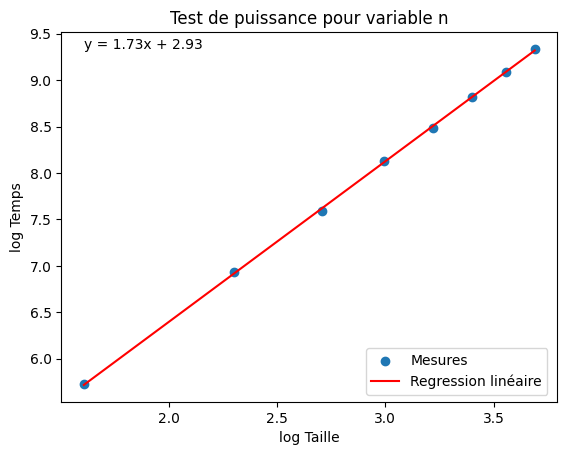

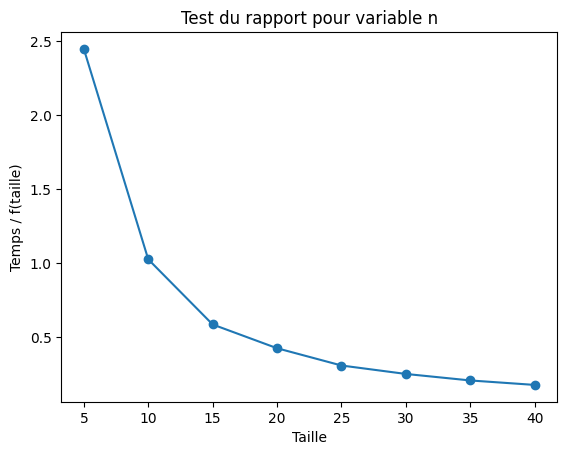

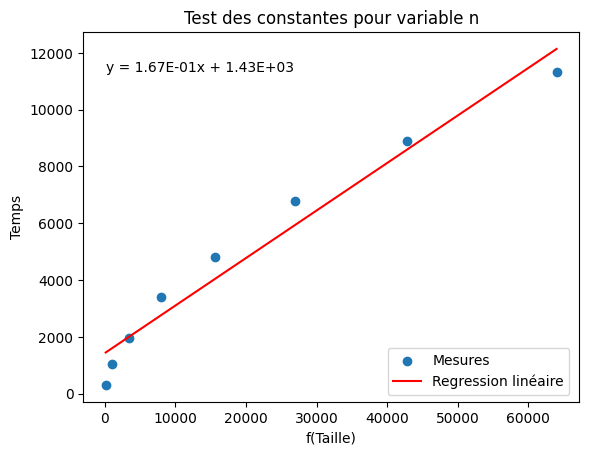

In [20]:
def values_test_puissance(measures: List[Measure]):
    return {
        math.log(measure.n): math.log(measure.mean_time_ms)
        for measure in measures
    }

def values_test_rapport(measures: List[Measure], f):
    return {
        measure.n: measure.mean_time_ms / f(measure.n)
        for measure in measures
    }

def values_test_constantes(measures: List[Measure], f):
    return {
        f(measure.n): measure.mean_time_ms
        for measure in measures
    }

def f(n):
    return n**3


vals_puissance_sa_n = values_test_puissance(results_sa_n)
vals_rapport_sa_n = values_test_rapport(results_sa_n, f)
vals_constantes_sa_n = values_test_constantes(results_sa_n, f)

display_test_puissance(vals_puissance_sa_n, "Test de puissance pour variable n")
display_test_rapport(vals_rapport_sa_n, "Test du rapport pour variable n")
display_test_constantes(vals_constantes_sa_n, "Test des constantes pour variable n")

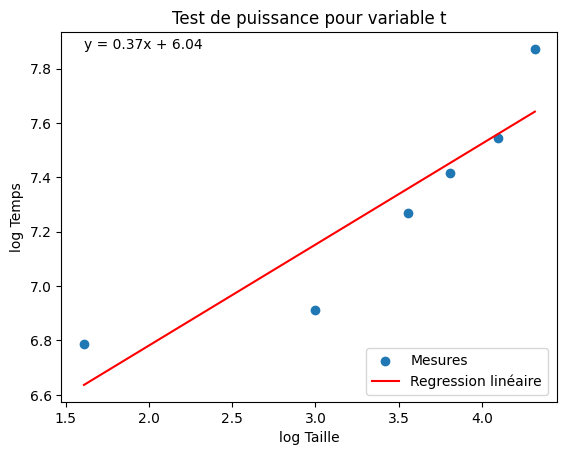

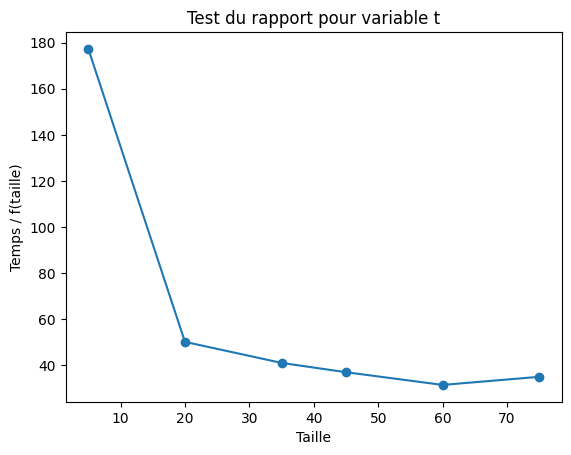

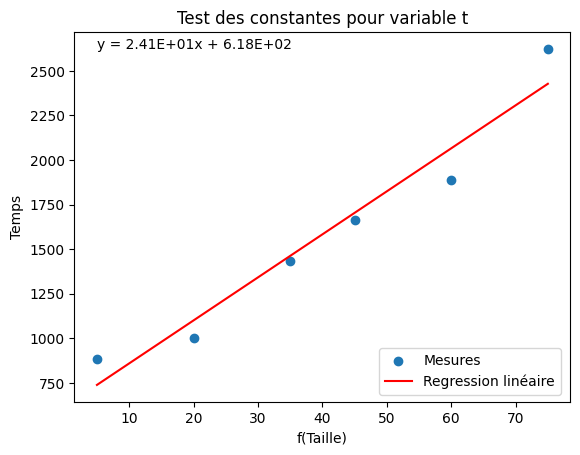

In [21]:
def values_test_puissance(measures: List[Measure]):
    return {
        math.log(measure.nb_targets): math.log(measure.mean_time_ms)
        for measure in measures
    }

def values_test_rapport(measures: List[Measure], f):
    return {
        measure.nb_targets: measure.mean_time_ms / f(measure.nb_targets)
        for measure in measures
    }

def values_test_constantes(measures: List[Measure], f):
    return {
        f(measure.nb_targets): measure.mean_time_ms
        for measure in measures
    }

def f(t):
    return t


vals_puissance_sa_t = values_test_puissance(results_sa_t)
vals_rapport_sa_t = values_test_rapport(results_sa_t, f)
vals_constantes_sa_t = values_test_constantes(results_sa_t, f)

display_test_puissance(vals_puissance_sa_t, "Test de puissance pour variable t")
display_test_rapport(vals_rapport_sa_t, "Test du rapport pour variable t")
display_test_constantes(vals_constantes_sa_t, "Test des constantes pour variable t")

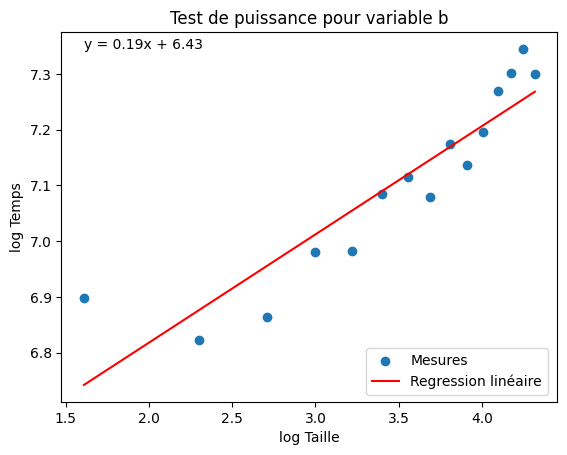

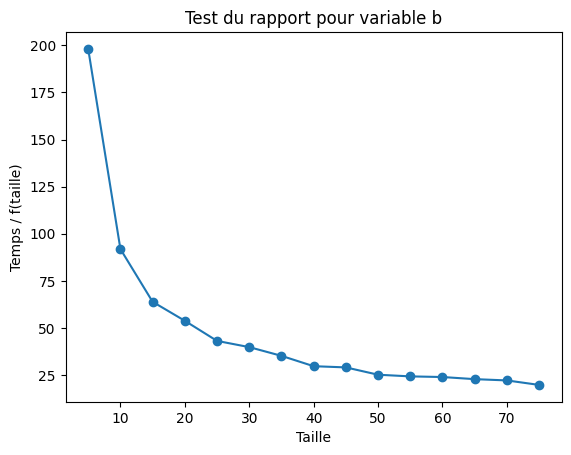

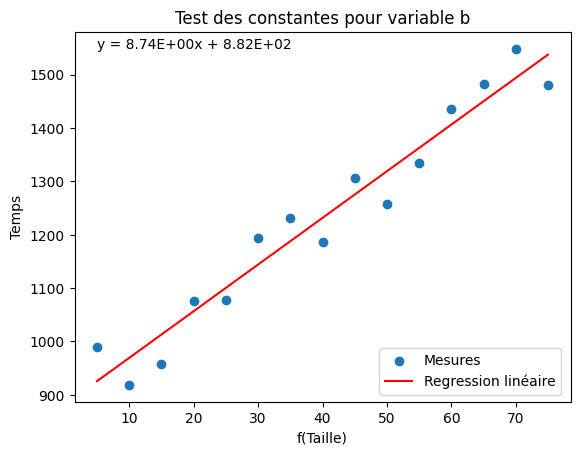

In [22]:
def values_test_puissance(measures: List[Measure]):
    return {
        math.log(measure.nb_banned): math.log(measure.mean_time_ms)
        for measure in measures
    }

def values_test_rapport(measures: List[Measure], f):
    return {
        measure.nb_banned: measure.mean_time_ms / f(measure.nb_banned)
        for measure in measures
    }

def values_test_constantes(measures: List[Measure], f):
    return {
        f(measure.nb_banned): measure.mean_time_ms
        for measure in measures
    }

def f(b):
    return b


vals_puissance_sa_b = values_test_puissance(results_sa_b)
vals_rapport_sa_b = values_test_rapport(results_sa_b, f)
vals_constantes_sa_b = values_test_constantes(results_sa_b, f)

display_test_puissance(vals_puissance_sa_b, "Test de puissance pour variable b")
display_test_rapport(vals_rapport_sa_b, "Test du rapport pour variable b")
display_test_constantes(vals_constantes_sa_b, "Test des constantes pour variable b")

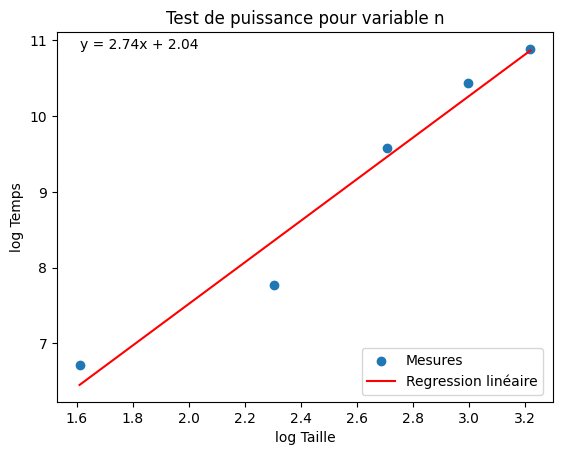

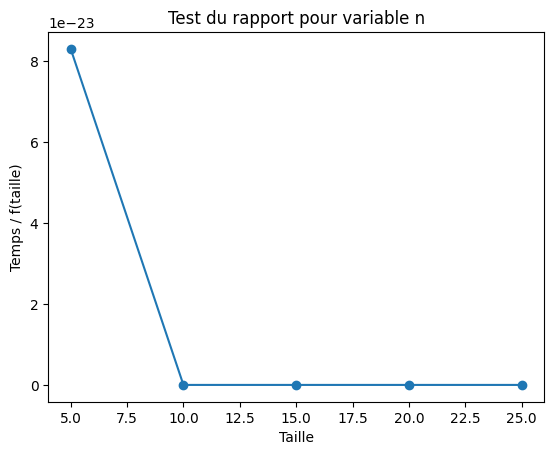

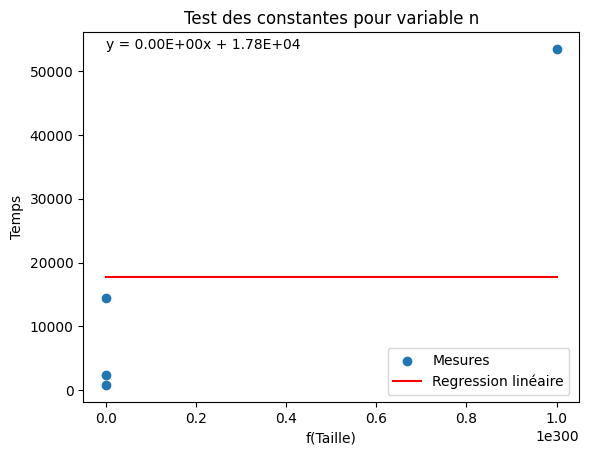

In [39]:
def values_test_puissance(measures: List[Measure]):
    return {
        math.log(measure.n): math.log(measure.mean_time_ms)
        for measure in measures
    }

def values_test_rapport(measures: List[Measure], f):
    return {
        measure.n: measure.mean_time_ms / (min(f(measure.alphabet_size, measure.n), 1e300)) # avoid overflow
        for measure in measures
    }

def values_test_constantes(measures: List[Measure], f):
    return {
        (min(f(measure.alphabet_size, measure.n), 1e300)): measure.mean_time_ms # avoid overflow
        for measure in measures
    }

def f(a, n):
    return a**(n*n)


vals_puissance_cp_n = values_test_puissance(results_cp_n)
vals_rapport_cp_n = values_test_rapport(results_cp_n, f)
vals_constantes_cp_n = values_test_constantes(results_cp_n, f)

display_test_puissance(vals_puissance_cp_n, "Test de puissance pour variable n")
display_test_rapport(vals_rapport_cp_n, "Test du rapport pour variable n")
display_test_constantes(vals_constantes_cp_n, "Test des constantes pour variable n")

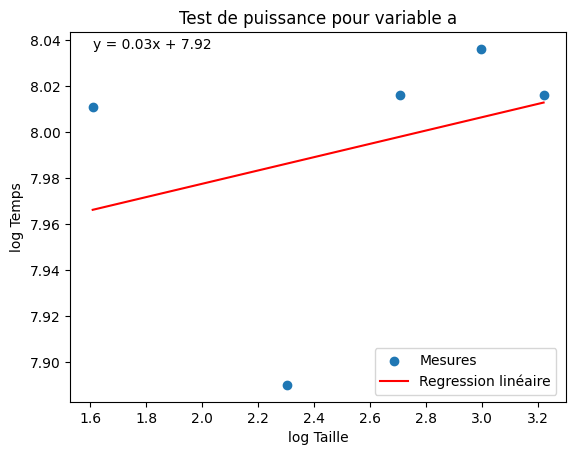

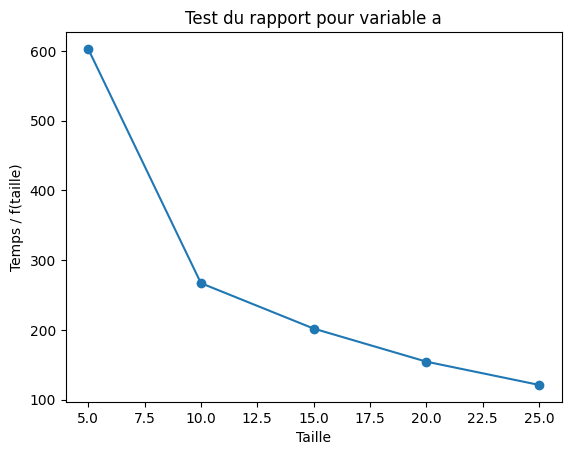

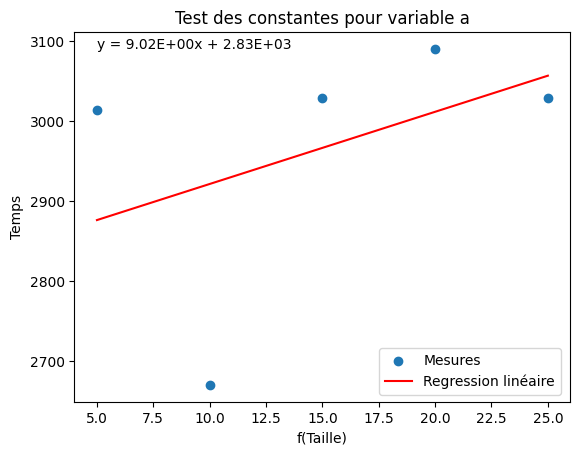

In [26]:
def values_test_puissance(measures: List[Measure]):
    return {
        math.log(measure.alphabet_size): math.log(measure.mean_time_ms)
        for measure in measures
    }

def values_test_rapport(measures: List[Measure], f):
    return {
        measure.alphabet_size: measure.mean_time_ms / f(measure.alphabet_size)
        for measure in measures
    }

def values_test_constantes(measures: List[Measure], f):
    return {
        f(measure.alphabet_size): measure.mean_time_ms
        for measure in measures
    }

def f(a):
    return a


vals_puissance_cp_a = values_test_puissance(results_cp_a)
vals_rapport_cp_a = values_test_rapport(results_cp_a, f)
vals_constantes_cp_a = values_test_constantes(results_cp_a, f)

display_test_puissance(vals_puissance_cp_a, "Test de puissance pour variable a")
display_test_rapport(vals_rapport_cp_a, "Test du rapport pour variable a")
display_test_constantes(vals_constantes_cp_a, "Test des constantes pour variable a")

#### Méthodologie des tests
> Hypothèse de départ (provenant de l'analyse asymptotique) : le temps d'exécution $T(n)\in O((t+b)n^3)$. <br>
> Le but est de cette analyse hybride est de venir confirmer et précisier l'analyse asymptotique de notre algorithme de recuit simulé avec les trois types de tests vus en classe. Pour cela, nous allons utiliser les méthodes suivantes : le test de puissance, le test du rapport et le test des constantes.<br>
> Avant de commencer, précisons que le nombre d'itérations ($i$) pour le `simulated_annealing()` à été borné supérieurement à 1000 itérations.

> Nous testerons les paramètres suivants :
> - $n$ : Dimension d'un carré nxn où $1 \leq n \leq 40$
> - $t$ : Nombre de séquences `targets` où $1 \leq n \leq 35$
> - $b$ : Nombre de séquences `banned` où $1 \leq n \leq 35$
> - $a$ : Nombre de symboles permis dans l'alphabet où $1 \leq n \leq 25$

> Pour nous permettre de tester seulement une variable qui nous intéresse, toutes les autres valeurs seront fixées de la manière suivante : $n=10$, $t=10$, $b=10$ et $a=10$.

> Soit : 
> - $x$ : la dimension d'un carré de taille $n$
> - $y$ : le temps d'exécution de l'algorithme.

### 1. Analyse hybride de la variable n
> **Hypothèse pour n** : Le taux de croissance de variable $n$ croît selon la fonction $f(x) = x^3$.<br>
> **Valeurs de n** : n prend les valeurs suivantes : ${5, 10, 15, 20, 25, 30, 35, 40}$

> **1.1 <u>Test de puissance</u>**<br>
> - <u>But</u> : Le test de puissance permet de déterminer le taux de croissance d'un l'algorithme. On l'applique en plaçant les couples $(x,y)$ sur une échelle log-log. Ce test est utile lorsqu'on n'a pas d'idée précise du taux de croissance. Contrairement au test du rapport qui sert plutôt à valider une hypothèse précise (souvent celle de l'analyse asymptotique). Il est tout de même intéressant d'effectuer ce test, ne serait-ce que pour en comparer le résultat avec le test du rapport.
> - <u>Analyse du graphe</u> : En observant le graphe, on constate que la majorité des points sont alignés sur la droite de régression représentée en rouge. L'équation de la droite est : $y = 1.73x + 2.93$.
> - <u>Interprétation</u> : Cette corrélation des points avec la droite nous indique un taux de croissance polynomial dont le dégré est donné par la valeur de la pente ($1.73$). Cette valeur n'est malheureusement pas cohérent avec notre hypothèse de départ ($T(n) \in O(n^3)$).

> **1.2. <u>Test du rapport</u>**<br>
> - <u>But</u> : Comme mentionné précédemment, le test du rapport sert à valider si le taux de croissance croît selon une fonction $f(x)$. Il est obtenu en plaçant les couples $(x,y/f(x))$ sur une échelle normale. Comme nous avons obtenu $T(n) \in O(n^3)$ durant l'analyse asymptotique, posons comme hypothèse $f(x) = x^3$.
> - <u>Analyse du graphe</u> : En observant le graphe, on constate que les valeurs convergent vers 0.1.
> - <u>Interprétation</u> : Le résultat de ce test appuie notre hypothèse, puisqu'une convergence vers une constante non nulle indique que notre fonction d'estimation a un taux de croissance similaire.

> **1.3. <u>Test des constantes</u>**<br> 
> - <u>But</u> : Le test des constantes permet de venir préciser $f(x)$, la fonction associée au taux de croissance. Le graphe est obtenu en plaçant les couples $(f(x),y)$ sur une échelle normale. Notre hypothèse pour $f(x)$ reste inchangé et nous posons $f(x)=x^3$.
> - <u>Analyse du graphe</u> : Visuellement, on remarque que la majorité des points (4 sur 6) ne sont pas du tout sur la droite de régression. De plus, les points semblent former une courbe plutôt qu'une droite.
> - <u>Interprétation</u> : À vue d'oeil, il ne nous semble pas possible de faire passer une droite à travers le nuage de points. Selon les notes de cours, cela voudrait dire que notre hypothèse est erronée.

> **<u>Conclusion</u>**<br>
> En conclusion, les résultats des tests ne permettent pas d'appuyer notre hypothèse de départ ($T(n) \in O(n^3)$).

### 2. Analyse hybride de la variable t
> **Hypothèse pour t** : Le taux de croissance de variable $t$ croît selon la fonction $f(x) = x$.

> **2.1 <u>Test de puissance</u>**<br>
> - <u>Analyse du graphe</u> : Visuellement, les points ne forment pas du tout une droite. Ils présentent une tendance positive, mais ne dessinent ni une courbe ni une droite.
> - <u>Interprétation</u> : Inconclusif, puisqu'il y a trop de bruits pour déterminer la forme.

> **2.2. <u>Test du rapport</u>**<br>
> - <u>Analyse du graphe</u> : Visuellement, les points semblent converger vers 30.
> - <u>Interprétation</u> : La convergence vers une constante non nulle nous indique que notre hypothèse est valide. 

> **2.3. <u>Test des constantes</u>**<br> 
> - <u>Analyse du graphe</u> : Même si seulement un des points touche la droite de régression, les points semblent dessiner une droite, puisque visuellement la somme des distances absolues entre les points et la droite semble petite.
> - <u>Interprétation</u> : Selon nous, il est possible de faire passer une droite à travers ce nuages de points. La pente de la droite ($143$) constituerait alors la constante multiplicative et l'ordonnée à l'origine nous donnerait le coût est de $6.18E+02$.

> **<u>Conclusion</u>**<br>
> En conclusion, la majorité des résultats (2/3) appuient notre hypothèse. Les résultats des tests concordent donc avec notre hypothèse.

### 3. Analyse hybride de la variable b
> **Hypothèse pour b** : Le taux de croissance de variable $b$ croît en temps linéaire selon la fonction $f(x) = x$.

> **3.1 <u>Test de puissance</u>**<br>
> - <u>Analyse du graphe</u> : On observe que la droite de régression obtenue est ( y = 0.19x + 6.43 ), alors que les points ne semblent pas du tout former une droite. On remarque également que le premier point est même plus élevé que les deuxième et troisième points, avec un log(T) de 6.9.

> - <u>Interprétation</u> : Le premier point peut être considéré comme une donnée aberrante, puisqu’il n’est pas censé prendre plus de temps que les problèmes ayant une valeur de b plus grande. Donc, si l’on ignore ce premier point, le reste des données semble visuellement former une droite de pente 1. Ainsi, on peut conclure que le résultat de ce test concorde avec notre hypothèse.

> **3.2. <u>Test du rapport</u>**<br>
> - <u>Analyse du graphe</u> : Visuellement, au fur et à mesure que la taille augmente, les points semblent converger vers une constante non nulle 25.
> - <u>Interprétation</u> : Cela nous indique que notre hypothèse est valide.

> **3.3. <u>Test des constantes</u>**<br> 
> - <u>Analyse du graphe</u> : Visuellement, les point s'alignent plus ou moins sur la droite, mais ne sont pas trop éloignés. L'équation de la droite est de $y=8.74x+8.82E02$.
> - <u>Interprétation</u> : Selon nous, il est possible de faire passer une droite à travers ce nuages de points, car même si les points ne touchent pas la droite, leurs distances entre la droite sont petites.

> **<u>Conclusion</u>**<br>
> Tous les résultats concordent avec notre hypothèse.

### 4. Analyse hybride de la variable n
> Malheureusement, puisque la complexité dans ce cas est super-exponentielle $(O(a^{n^2}))$, les trois tests ne fonctionnent pas ici. Ainsi, on ne peut pas conclure sur la complexité en fonction de $n$.

### 5. Analyse hybride de la variable a
> **Hypothèse pour a** : Le taux de croissance de variable $a$ croît en temps linéaire selon la fonction $f(x) = x$.

> **3.1 <u>Test de puissance</u>**<br>
> - <u>Analyse du graphe</u> : On observe que les points fluctuent beaucoup et que la pente de la droite de régression est presque nulle.

> - <u>Interprétation</u> : Le test est inconclusif, puisqu'il y a trop de données aberrantes, les points fluctuent trop et il n'y a pas assez de points pour appuyer notre hypothèse.

> **3.2. <u>Test du rapport</u>**<br>
> - <u>Analyse du graphe</u> : Visuellement, au fur et à mesure que la taille augmente, les points semblent converger vers une constante non nulle 100.
> - <u>Interprétation</u> : Cela nous indique que notre hypothèse est valide.

> **3.3. <u>Test des constantes</u>**<br> 
> - <u>Analyse du graphe</u> : Visuellement, les points ne s’alignent pas sur la droite, et le deuxième point constitue une donnée aberrante puisqu’il est trop éloigné des autres.
> - <u>Interprétation</u> : Si l’on ignore le deuxième point, le reste des données semble pouvoir former une droite. Ainsi, on peut dire que cela concorde avec notre hypothèse.

> **<u>Conclusion</u>**<br>
> La majorité des résultats (2/3) concordent avec notre hypothèse.

# Analyse code carbon (1 pts)

Effectuer une anlayse code carbon en sélectionnant différent pays pour l'analyse. Commenter vos résultats.


In [28]:
import pandas as pd
from codecarbon import EmissionsTracker

def measure_carbon_from_dataset(dataset, procedure):
    results = []

    for samples in dataset:
        pb = samples[0]

        print(f"--- Mesure carbone pour n={pb.n}, t={len(pb.targets)}, b={len(pb.banned)}, a={len(pb.alphabet)} ---")

        tracker = EmissionsTracker(
            measure_power_secs=5,
            tracking_mode="process"
        )

        tracker.start()
        procedure(pb)
        tracker.stop()

        df = pd.read_csv("emissions.csv")
        row = df.iloc[-1]

        results.append({
            "n": pb.n,
            "targets": len(pb.targets),
            "banned": len(pb.banned),
            "alphabet_size": len(pb.alphabet),
            "duration (s)": row["duration"],
            "emissions (kg CO2-eq)": row["emissions"],
            "emissions_rate (kg/s)": row["emissions_rate"],
            "energy_consumed (kWh)": row["energy_consumed"],
        })

    return pd.DataFrame(results)

In [29]:
df_carbon_sa_n = measure_carbon_from_dataset(dataset_sa_n, simulated_annealing)
df_carbon_sa_t = measure_carbon_from_dataset(dataset_sa_t, simulated_annealing)
df_carbon_sa_b = measure_carbon_from_dataset(dataset_sa_b, simulated_annealing)
df_carbon_cp_n = measure_carbon_from_dataset(dataset_cp_n, constraint_programming)
df_carbon_cp_a = measure_carbon_from_dataset(dataset_cp_a, constraint_programming)

[codecarbon WARNING @ 21:09:34] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 21:09:34] [setup] RAM Tracking...
[codecarbon INFO @ 21:09:34] [setup] CPU Tracking...


--- Mesure carbone pour n=5, t=10, b=10, a=10 ---


[codecarbon WARNING @ 21:09:38] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:09:38] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:09:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:09:38] [setup] GPU Tracking...
[codecarbon INFO @ 21:09:38] No GPU found.
[codecarbon INFO @ 21:09:38] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:09:38] >>> Tracker's metadata:
[codecarbon INFO @ 21:09:38]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:09:38]   Python version: 3.13.7
[codecarbon INFO @ 21:09:38]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=10, a=10 ---


[codecarbon WARNING @ 21:09:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:09:44] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:09:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:09:44] [setup] GPU Tracking...
[codecarbon INFO @ 21:09:44] No GPU found.
[codecarbon INFO @ 21:09:44] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:09:44] >>> Tracker's metadata:
[codecarbon INFO @ 21:09:44]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:09:44]   Python version: 3.13.7
[codecarbon INFO @ 21:09:44]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=15, t=10, b=10, a=10 ---


[codecarbon WARNING @ 21:09:54] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:09:54] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:09:54] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:09:54] [setup] GPU Tracking...
[codecarbon INFO @ 21:09:54] No GPU found.
[codecarbon INFO @ 21:09:54] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:09:54] >>> Tracker's metadata:
[codecarbon INFO @ 21:09:54]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:09:54]   Python version: 3.13.7
[codecarbon INFO @ 21:09:54]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=20, t=10, b=10, a=10 ---


[codecarbon WARNING @ 21:10:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:10:08] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:10:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:10:08] [setup] GPU Tracking...
[codecarbon INFO @ 21:10:08] No GPU found.
[codecarbon INFO @ 21:10:08] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:10:08] >>> Tracker's metadata:
[codecarbon INFO @ 21:10:08]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:10:08]   Python version: 3.13.7
[codecarbon INFO @ 21:10:08]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=25, t=10, b=10, a=10 ---


[codecarbon WARNING @ 21:10:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:10:26] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:10:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:10:26] [setup] GPU Tracking...
[codecarbon INFO @ 21:10:26] No GPU found.
[codecarbon INFO @ 21:10:26] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:10:26] >>> Tracker's metadata:
[codecarbon INFO @ 21:10:26]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:10:26]   Python version: 3.13.7
[codecarbon INFO @ 21:10:26]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=30, t=10, b=10, a=10 ---


[codecarbon WARNING @ 21:10:43] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:10:43] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:10:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:10:43] [setup] GPU Tracking...
[codecarbon INFO @ 21:10:43] No GPU found.
[codecarbon INFO @ 21:10:43] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:10:43] >>> Tracker's metadata:
[codecarbon INFO @ 21:10:43]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:10:43]   Python version: 3.13.7
[codecarbon INFO @ 21:10:43]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=35, t=10, b=10, a=10 ---


[codecarbon WARNING @ 21:11:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:11:02] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:11:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:11:02] [setup] GPU Tracking...
[codecarbon INFO @ 21:11:02] No GPU found.
[codecarbon INFO @ 21:11:02] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:11:02] >>> Tracker's metadata:
[codecarbon INFO @ 21:11:02]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:11:02]   Python version: 3.13.7
[codecarbon INFO @ 21:11:02]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=40, t=10, b=10, a=10 ---


[codecarbon WARNING @ 21:11:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:11:24] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:11:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:11:24] [setup] GPU Tracking...
[codecarbon INFO @ 21:11:24] No GPU found.
[codecarbon INFO @ 21:11:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:11:24] >>> Tracker's metadata:
[codecarbon INFO @ 21:11:24]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:11:24]   Python version: 3.13.7
[codecarbon INFO @ 21:11:24]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=5, b=10, a=10 ---


[codecarbon WARNING @ 21:12:13] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:12:13] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:12:13] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:12:13] [setup] GPU Tracking...
[codecarbon INFO @ 21:12:13] No GPU found.
[codecarbon INFO @ 21:12:13] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:12:13] >>> Tracker's metadata:
[codecarbon INFO @ 21:12:13]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:12:13]   Python version: 3.13.7
[codecarbon INFO @ 21:12:13]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=20, b=10, a=10 ---


[codecarbon WARNING @ 21:12:21] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:12:21] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:12:21] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:12:21] [setup] GPU Tracking...
[codecarbon INFO @ 21:12:21] No GPU found.
[codecarbon INFO @ 21:12:21] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:12:21] >>> Tracker's metadata:
[codecarbon INFO @ 21:12:21]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:12:21]   Python version: 3.13.7
[codecarbon INFO @ 21:12:21]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=35, b=10, a=10 ---


[codecarbon WARNING @ 21:12:29] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:12:29] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:12:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:12:29] [setup] GPU Tracking...
[codecarbon INFO @ 21:12:29] No GPU found.
[codecarbon INFO @ 21:12:29] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:12:29] >>> Tracker's metadata:
[codecarbon INFO @ 21:12:29]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:12:29]   Python version: 3.13.7
[codecarbon INFO @ 21:12:29]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=45, b=10, a=10 ---


[codecarbon WARNING @ 21:12:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:12:37] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:12:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:12:37] [setup] GPU Tracking...
[codecarbon INFO @ 21:12:37] No GPU found.
[codecarbon INFO @ 21:12:37] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:12:37] >>> Tracker's metadata:
[codecarbon INFO @ 21:12:37]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:12:37]   Python version: 3.13.7
[codecarbon INFO @ 21:12:37]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=60, b=10, a=10 ---


[codecarbon WARNING @ 21:12:45] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:12:45] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:12:45] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:12:45] [setup] GPU Tracking...
[codecarbon INFO @ 21:12:45] No GPU found.
[codecarbon INFO @ 21:12:45] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:12:45] >>> Tracker's metadata:
[codecarbon INFO @ 21:12:45]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:12:45]   Python version: 3.13.7
[codecarbon INFO @ 21:12:45]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=75, b=10, a=10 ---


[codecarbon WARNING @ 21:12:53] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:12:53] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:12:53] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:12:53] [setup] GPU Tracking...
[codecarbon INFO @ 21:12:53] No GPU found.
[codecarbon INFO @ 21:12:53] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:12:53] >>> Tracker's metadata:
[codecarbon INFO @ 21:12:53]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:12:53]   Python version: 3.13.7
[codecarbon INFO @ 21:12:53]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=5, a=10 ---


[codecarbon WARNING @ 21:13:04] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:13:04] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:13:04] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:13:04] [setup] GPU Tracking...
[codecarbon INFO @ 21:13:04] No GPU found.
[codecarbon INFO @ 21:13:04] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:13:04] >>> Tracker's metadata:
[codecarbon INFO @ 21:13:04]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:13:04]   Python version: 3.13.7
[codecarbon INFO @ 21:13:04]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=10, a=10 ---


[codecarbon WARNING @ 21:13:11] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:13:11] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:13:11] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:13:11] [setup] GPU Tracking...
[codecarbon INFO @ 21:13:11] No GPU found.
[codecarbon INFO @ 21:13:11] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:13:11] >>> Tracker's metadata:
[codecarbon INFO @ 21:13:11]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:13:11]   Python version: 3.13.7
[codecarbon INFO @ 21:13:11]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=15, a=10 ---


[codecarbon WARNING @ 21:13:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:13:18] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:13:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:13:18] [setup] GPU Tracking...
[codecarbon INFO @ 21:13:18] No GPU found.
[codecarbon INFO @ 21:13:18] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:13:18] >>> Tracker's metadata:
[codecarbon INFO @ 21:13:18]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:13:18]   Python version: 3.13.7
[codecarbon INFO @ 21:13:18]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=20, a=10 ---


[codecarbon WARNING @ 21:13:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:13:26] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:13:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:13:26] [setup] GPU Tracking...
[codecarbon INFO @ 21:13:26] No GPU found.
[codecarbon INFO @ 21:13:26] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:13:26] >>> Tracker's metadata:
[codecarbon INFO @ 21:13:26]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:13:26]   Python version: 3.13.7
[codecarbon INFO @ 21:13:26]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=25, a=10 ---


[codecarbon WARNING @ 21:13:33] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:13:33] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:13:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:13:33] [setup] GPU Tracking...
[codecarbon INFO @ 21:13:33] No GPU found.
[codecarbon INFO @ 21:13:33] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:13:33] >>> Tracker's metadata:
[codecarbon INFO @ 21:13:33]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:13:33]   Python version: 3.13.7
[codecarbon INFO @ 21:13:33]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=30, a=10 ---


[codecarbon WARNING @ 21:13:41] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:13:41] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:13:41] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:13:41] [setup] GPU Tracking...
[codecarbon INFO @ 21:13:41] No GPU found.
[codecarbon INFO @ 21:13:41] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:13:41] >>> Tracker's metadata:
[codecarbon INFO @ 21:13:41]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:13:41]   Python version: 3.13.7
[codecarbon INFO @ 21:13:41]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=35, a=10 ---


[codecarbon WARNING @ 21:13:50] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:13:50] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:13:50] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:13:50] [setup] GPU Tracking...
[codecarbon INFO @ 21:13:50] No GPU found.
[codecarbon INFO @ 21:13:50] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:13:50] >>> Tracker's metadata:
[codecarbon INFO @ 21:13:50]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:13:50]   Python version: 3.13.7
[codecarbon INFO @ 21:13:50]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=40, a=10 ---


[codecarbon WARNING @ 21:13:58] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:13:58] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:13:58] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:13:58] [setup] GPU Tracking...
[codecarbon INFO @ 21:13:58] No GPU found.
[codecarbon INFO @ 21:13:58] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:13:58] >>> Tracker's metadata:
[codecarbon INFO @ 21:13:58]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:13:58]   Python version: 3.13.7
[codecarbon INFO @ 21:13:58]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=45, a=10 ---


[codecarbon WARNING @ 21:14:07] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:14:07] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:14:07] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:14:07] [setup] GPU Tracking...
[codecarbon INFO @ 21:14:07] No GPU found.
[codecarbon INFO @ 21:14:07] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:14:07] >>> Tracker's metadata:
[codecarbon INFO @ 21:14:07]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:14:07]   Python version: 3.13.7
[codecarbon INFO @ 21:14:07]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=50, a=10 ---


[codecarbon WARNING @ 21:14:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:14:16] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:14:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:14:16] [setup] GPU Tracking...
[codecarbon INFO @ 21:14:16] No GPU found.
[codecarbon INFO @ 21:14:16] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:14:16] >>> Tracker's metadata:
[codecarbon INFO @ 21:14:16]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:14:16]   Python version: 3.13.7
[codecarbon INFO @ 21:14:16]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=55, a=10 ---


[codecarbon WARNING @ 21:14:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:14:24] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:14:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:14:24] [setup] GPU Tracking...
[codecarbon INFO @ 21:14:24] No GPU found.
[codecarbon INFO @ 21:14:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:14:24] >>> Tracker's metadata:
[codecarbon INFO @ 21:14:24]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:14:24]   Python version: 3.13.7
[codecarbon INFO @ 21:14:24]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=60, a=10 ---


[codecarbon WARNING @ 21:14:33] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:14:33] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:14:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:14:33] [setup] GPU Tracking...
[codecarbon INFO @ 21:14:33] No GPU found.
[codecarbon INFO @ 21:14:33] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:14:33] >>> Tracker's metadata:
[codecarbon INFO @ 21:14:33]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:14:33]   Python version: 3.13.7
[codecarbon INFO @ 21:14:33]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=65, a=10 ---


[codecarbon WARNING @ 21:14:42] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:14:42] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:14:42] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:14:42] [setup] GPU Tracking...
[codecarbon INFO @ 21:14:42] No GPU found.
[codecarbon INFO @ 21:14:42] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:14:42] >>> Tracker's metadata:
[codecarbon INFO @ 21:14:42]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:14:42]   Python version: 3.13.7
[codecarbon INFO @ 21:14:42]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=70, a=10 ---


[codecarbon WARNING @ 21:14:50] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:14:50] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:14:50] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:14:50] [setup] GPU Tracking...
[codecarbon INFO @ 21:14:50] No GPU found.
[codecarbon INFO @ 21:14:50] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:14:50] >>> Tracker's metadata:
[codecarbon INFO @ 21:14:50]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:14:50]   Python version: 3.13.7
[codecarbon INFO @ 21:14:50]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=75, a=10 ---


[codecarbon WARNING @ 21:14:58] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:14:58] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:14:58] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:14:58] [setup] GPU Tracking...
[codecarbon INFO @ 21:14:58] No GPU found.
[codecarbon INFO @ 21:14:58] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:14:58] >>> Tracker's metadata:
[codecarbon INFO @ 21:14:58]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:14:58]   Python version: 3.13.7
[codecarbon INFO @ 21:14:58]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=5, t=10, b=10, a=10 ---


[codecarbon WARNING @ 21:15:07] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:15:07] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:15:07] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:15:07] [setup] GPU Tracking...
[codecarbon INFO @ 21:15:07] No GPU found.
[codecarbon INFO @ 21:15:07] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:15:07] >>> Tracker's metadata:
[codecarbon INFO @ 21:15:07]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:15:07]   Python version: 3.13.7
[codecarbon INFO @ 21:15:07]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=10, a=10 ---


[codecarbon WARNING @ 21:15:15] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:15:15] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:15:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:15:15] [setup] GPU Tracking...
[codecarbon INFO @ 21:15:15] No GPU found.
[codecarbon INFO @ 21:15:15] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:15:15] >>> Tracker's metadata:
[codecarbon INFO @ 21:15:15]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:15:15]   Python version: 3.13.7
[codecarbon INFO @ 21:15:15]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=15, t=10, b=10, a=10 ---


[codecarbon WARNING @ 21:15:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:15:24] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:15:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:15:24] [setup] GPU Tracking...
[codecarbon INFO @ 21:15:24] No GPU found.
[codecarbon INFO @ 21:15:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:15:24] >>> Tracker's metadata:
[codecarbon INFO @ 21:15:24]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:15:24]   Python version: 3.13.7
[codecarbon INFO @ 21:15:24]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=20, t=10, b=10, a=10 ---


[codecarbon WARNING @ 21:15:41] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:15:41] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:15:41] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:15:41] [setup] GPU Tracking...
[codecarbon INFO @ 21:15:41] No GPU found.
[codecarbon INFO @ 21:15:41] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:15:41] >>> Tracker's metadata:
[codecarbon INFO @ 21:15:41]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:15:41]   Python version: 3.13.7
[codecarbon INFO @ 21:15:41]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=25, t=10, b=10, a=10 ---


[codecarbon WARNING @ 21:16:07] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:16:07] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:16:07] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:16:07] [setup] GPU Tracking...
[codecarbon INFO @ 21:16:07] No GPU found.
[codecarbon INFO @ 21:16:07] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:16:07] >>> Tracker's metadata:
[codecarbon INFO @ 21:16:07]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:16:07]   Python version: 3.13.7
[codecarbon INFO @ 21:16:07]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=10, a=5 ---


[codecarbon WARNING @ 21:17:11] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:17:11] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:17:11] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:17:11] [setup] GPU Tracking...
[codecarbon INFO @ 21:17:11] No GPU found.
[codecarbon INFO @ 21:17:11] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:17:11] >>> Tracker's metadata:
[codecarbon INFO @ 21:17:11]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:17:11]   Python version: 3.13.7
[codecarbon INFO @ 21:17:11]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=10, a=10 ---


[codecarbon WARNING @ 21:17:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:17:20] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:17:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:17:20] [setup] GPU Tracking...
[codecarbon INFO @ 21:17:20] No GPU found.
[codecarbon INFO @ 21:17:20] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:17:20] >>> Tracker's metadata:
[codecarbon INFO @ 21:17:20]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:17:20]   Python version: 3.13.7
[codecarbon INFO @ 21:17:20]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=10, a=15 ---


[codecarbon WARNING @ 21:17:29] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:17:29] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:17:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:17:29] [setup] GPU Tracking...
[codecarbon INFO @ 21:17:29] No GPU found.
[codecarbon INFO @ 21:17:29] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:17:29] >>> Tracker's metadata:
[codecarbon INFO @ 21:17:29]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:17:29]   Python version: 3.13.7
[codecarbon INFO @ 21:17:29]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=10, a=20 ---


[codecarbon WARNING @ 21:17:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:17:36] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:17:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:17:36] [setup] GPU Tracking...
[codecarbon INFO @ 21:17:37] No GPU found.
[codecarbon INFO @ 21:17:37] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:17:37] >>> Tracker's metadata:
[codecarbon INFO @ 21:17:37]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:17:37]   Python version: 3.13.7
[codecarbon INFO @ 21:17:37]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

--- Mesure carbone pour n=10, t=10, b=10, a=25 ---


[codecarbon WARNING @ 21:17:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:17:44] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
[codecarbon WARNING @ 21:17:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:17:44] [setup] GPU Tracking...
[codecarbon INFO @ 21:17:44] No GPU found.
[codecarbon INFO @ 21:17:44] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:17:44] >>> Tracker's metadata:
[codecarbon INFO @ 21:17:44]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 21:17:44]   Python version: 3.13.7
[codecarbon INFO @ 21:17:44]   CodeCarbon version: 3.0.8
[codecarbon INFO @ 2

In [32]:
df_carbon_sa_n

,n,targets,banned,alphabet_size,duration (s),emissions (kg CO2-eq),emissions_rate (kg/s),energy_consumed (kWh)
0,5,10,10,10,0.830576,1.102924e-07,1.327902e-07,0.000028
1,10,10,10,10,3.481293,4.634438e-07,1.331241e-07,0.000118
2,15,10,10,10,7.278564,9.469781e-07,1.301051e-07,0.000241
3,20,10,10,10,11.298434,1.456139e-06,1.288797e-07,0.000370
4,25,10,10,10,11.130411,1.416159e-06,1.272333e-07,0.000360
5,30,10,10,10,12.624276,1.639051e-06,1.298333e-07,0.000416
6,35,10,10,10,16.825131,2.149742e-06,1.277697e-07,0.000546
7,40,10,10,10,43.479062,5.586543e-06,1.284881e-07,0.001419


In [33]:
df_carbon_sa_t

,n,targets,banned,alphabet_size,duration (s),emissions (kg CO2-eq),emissions_rate (kg/s),energy_consumed (kWh)
0,10,5,10,10,2.031531,2.698706e-07,1.328410e-07,0.000069
1,10,20,10,10,2.564306,3.412802e-07,1.330887e-07,0.000087
2,10,35,10,10,2.242227,2.985431e-07,1.331458e-07,0.000076
3,10,45,10,10,2.497040,3.323710e-07,1.331060e-07,0.000084
4,10,60,10,10,2.539676,3.378566e-07,1.330314e-07,0.000086
5,10,75,10,10,5.155680,1.371978e-06,2.661100e-07,0.000348


In [34]:
df_carbon_sa_b

,n,targets,banned,alphabet_size,duration (s),emissions (kg CO2-eq),emissions_rate (kg/s),energy_consumed (kWh)
0,10,10,5,10,1.648136,2.190212e-07,1.328903e-07,0.000056
1,10,10,10,10,1.673436,2.226039e-07,1.330221e-07,0.000057
2,10,10,15,10,1.935827,2.576656e-07,1.331036e-07,0.000065
3,10,10,20,10,2.013947,2.675571e-07,1.328521e-07,0.000068
4,10,10,25,10,2.441381,3.250468e-07,1.331406e-07,0.000083
5,10,10,30,10,3.267786,4.355696e-07,1.332920e-07,0.000111
6,10,10,35,10,2.192170,2.916342e-07,1.330345e-07,0.000074
7,10,10,40,10,3.436233,4.577103e-07,1.332012e-07,0.000116
8,10,10,45,10,3.146023,4.191420e-07,1.332292e-07,0.000106
9,10,10,50,10,2.776136,3.697813e-07,1.332000e-07,0.000094


In [35]:
df_carbon_cp_n

,n,targets,banned,alphabet_size,duration (s),emissions (kg CO2-eq),emissions_rate (kg/s),energy_consumed (kWh)
0,5,10,10,10,3.256200,4.333951e-07,1.330985e-07,0.000110
1,10,10,10,10,2.620004,3.491205e-07,1.332519e-07,0.000089
2,15,10,10,10,12.077195,2.196411e-06,1.818644e-07,0.000558
3,20,10,10,10,20.046821,2.630886e-06,1.312371e-07,0.000668
4,25,10,10,10,58.510608,7.626207e-06,1.303389e-07,0.001937


In [36]:
df_carbon_cp_a

,n,targets,banned,alphabet_size,duration (s),emissions (kg CO2-eq),emissions_rate (kg/s),energy_consumed (kWh)
0,10,10,10,5,3.005065,4.004819e-07,1.332690e-07,0.000102
1,10,10,10,10,2.719006,3.622970e-07,1.332461e-07,0.000092
2,10,10,10,15,2.465366,3.285911e-07,1.332829e-07,0.000083
3,10,10,10,20,2.321034,3.088575e-07,1.330689e-07,0.000078
4,10,10,10,25,3.080038,4.098716e-07,1.330736e-07,0.000104


In [30]:
df_carbon_sa_n.to_excel("carbone_specs_sa_n.xlsx", index=False)
df_carbon_sa_t.to_excel("carbone_specs_sa_t.xlsx", index=False)
df_carbon_sa_b.to_excel("carbone_specs_sa_b.xlsx", index=False)
df_carbon_cp_n.to_excel("carbone_specs_cp_n.xlsx", index=False)
df_carbon_cp_a.to_excel("carbone_specs_cp_a.xlsx", index=False)

Nous utilisons la librairie CodeCarbon pour évaluer la consommation énergétique de notre algorithme de recuit simulé. Il s'agit de la même librairie que celle utilisée dans le TP2. Les variables ayant  retenues notre attention pour l'analyse sont : 
- <u>Durée</u> (`duration`) : Temps total d'exécution (secondes)
- <u>Émission</u> (`emissions`): Quantité de CO₂ émis (kg de CO₂ équivalent)
- <u>Taux d'émission</u> (`emissions_rate`) : Émission divisée par seconde (kg CO₂ éq / seconde)
- <u>Énergie consommée</u> (`energy_consumed`) : Énergie totale utilisée par le CPU, le GPU et la RAM (kWh)<br><br>

À l'instar de l'analyse hybride, les attributs testés sont :
> - $n$ : Dimension d'un carré nxn où $1 \leq n \leq 40$
> - $t$ : Nombre de séquences `targets` où $1 \leq n \leq 35$
> - $b$ : Nombre de séquences `banned` où $1 \leq n \leq 35$

> Pour nous permettre de tester seulement une variable qui nous intéresse, toutes les autres valeurs seront fixées de la manière suivante : $n=10$, $t=10$, $b=10$ et $a=10$.<br>

> <u>**Consommation énergétique en fonction de n**</u><br>
Au fur et à mesure que la taille du carré augmente : la durée, la quantité de CO₂ émis (ainsi que le taux d'émission) et l'énergie totale consommée augmente. Ce résultat est assez instinctif, plus la taille du carré est grand et plus il demandera de travail pour retourner une solution et consommera plus de ressources. 

> <u>**Consommation énergétique en fonction de b**</u><br>
Selon le tableau, plus le nombre de séquences bannies augmentent (de 5 à 75) et plus on observe une consommation accrue de toutes les ressources, que ce soit en terme de temps, d'énergie consommée. Mais aussi une augmentation des émissions de CO₂. On constate tout de même que durée varie très peu, mais qu'en ce qui concerne les émissions, taux d'émissions et énergie consommée, les valeurs sont très proches de ce qu'on obtient lorsqu'on fait varier seulement la taille du carré.

> <u>**Consommation énergétique en fonction de t**</u><br>
Dans ce 3e tableau, on fait varier t qui réprésente le nombre de séquences cibles. Similairement aux deux cas précédents, une augmentation de t va aussi entraîner une augmentation de la durée, des émissions et de l'énergie consommée. Les données obtenues entre le cas 3 (variation de t) et le cas 2 (variation de b) sont très similaires. C'est cohérent, puisque les deux variables sont utilisées de la même manière par l'algorithme.

> <u>**Consommation énergétique en fonction de n**</u><br>
Pour le $n$ de `constraint_programming()`, on remarque que la durée, l’émission et l’énergie consommée augmentent avec $n$ et croissent beaucoup plus rapidement que pour le $n$ de `simulated_annealing()` si l’on ignore la donnée aberrante en position 2.

> <u>**Consommation énergétique en fonction de a**</u><br>
Pour le $a$ de `constraint_programming()`, on remarque que la durée, l’émission et l’énergie consommée restent globalement stables au lieu d’augmenter avec la taille de $a$.

## Évolution de votre algorithme et Conclusion (6 pts)

Faites une synthèse de vos analyses pour mettre en évidence les qualités et défauts de votre algorithme. Mentionnez les améliorations qui vous ont permis d'atteindre votre algorithme actuel ainsi que des pistes d'améliorations potentielles restantes.

> En conclusion, les résultats sont partiellement **conclusifs**. Pour l’hypothèse sur la complexité de `simulated_annealing()` $(O((t+b) \cdot n^3))$, on parvient seulement à démontrer $t$ et $b$, mais pas celui de $n$. Quant à l’hypothèse initiale pour `constraint_programming()` $(O(a^{n^2}))$, on ne peut confirmer que $a$, pas celle de $n$.

> Il est possible que nos valeurs de (n), (t) et (b) soient trop petites pour permettre l’observation d’une tendance nette. Les tests de puissance, de rapport et des constantes ne deviennent réellement significatifs que pour de grandes valeurs de (x).

> Ainsi, nous ne pouvons ni confirmer ni infirmer complètement notre hypothèse initiale à partir des résultats obtenus : de petites valeurs de (n), (t) et (b), combinées à de faibles variations, ne permettent pas d’observer leur comportement asymptotique ni de conclure à une convergence.

> Enfin, pour l’analyse CodeCarbon, nous remarquons que le temps d’exécution est beaucoup plus sensible aux variations de (n) qu’à celles de (t) ou (b). Cela appuie partiellement notre hypothèse initiale, mais pas de manière définitive.


> Une des améliorations que nous avons apportées est l’intégration du **simulated annealing**. Au départ, nous n’avions qu’un **algorithme de recherche locale**, mais nous avons rapidement rencontré le problème des **optimums locaux**. Ainsi, après un certain temps, nous avons décidé d’utiliser l’algorithme de simulated annealing pour résoudre ce problème.

> Une autre amélioration que nous avons apportée consiste à résoudre le problème à l’aide de la programmation par contraintes pour des tailles modestes $(n \leq 25)$.
> Même si la programmation par contraintes présente une très mauvaise complexité asymptotique (exponentielle), cela ne pose pas de problème pour des instances de petite taille.
> L’avantage de cette approche est qu’elle permet de trouver des solutions optimales, ou au minimum des solutions faisables plus bonnes que celles obtenues par *simulated annealing*.

> Une amélioration que nous pourrions apporter consiste à optimiser la fonction **`eval_change()`**. Selon notre analyse asymptotique, cette fonction est la principale source de lenteur dans l’exécution de notre algorithme. En effet, **`eval_change()`** a une complexité temporelle de ($O((t+b)n^3)$), ce qui la rend extrêmement sensible à la taille de (n).

> Cependant, il est théoriquement possible de faire beaucoup mieux que notre implémentation actuelle. Dans sa forme actuelle, **`eval_change()`** recalcule entièrement le score de la grille, ce qui est très coûteux en ressources. À la place, nous pourrions calculer le score **une seule fois au début**, puis ne recalculer **que le changement de score** causé par les modifications de caractères.

> Pour ce faire, au départ, nous enregistrerions pour chaque case les *targets* et les *banned* auxquels elle contribue. Nous calculerions également la fréquence de chaque *target* et *banned*. Ensuite, lorsqu’on change le caractère d’une case, on diminue le compteur de chaque *target* ou *banned* auquel cette case contribuait auparavant. On examine ensuite la rangée et la colonne de la case modifiée pour voir si cela crée de nouveaux *targets* ou *banned*, et on incrémente les compteurs correspondants.

> Finalement, nous obtenons le nouveau score en calculant le nombre de *targets* dont le compteur est supérieur à 0, moins le nombre de *banned* dont le compteur est supérieur à 0. De cette manière, nous n’avons plus besoin d’examiner toutes les cases du tableau à chaque changement.

 ## Autres critères
 Qualité du code

Présentation générale

- Concision
- Qualité du français

Pénalité retard
- -2 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.